In [1]:
from Agent import Agent
from environment import GridWorld
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
env = GridWorld((10,10),0)

In [3]:
num_agents = 4
num_episodes = 1000

In [4]:
agents = []

In [5]:
def initiate_positions():
    for agent in agents:
        agent.reset(env)
    env.update_agents(agents)
    for agent in agents:
        agent.get_other_agents(env)

In [6]:
for i in range(num_agents):
    agents.append(Agent(5,0.002,4,128,env.observation_space,0.99,1,100,'cuda'))

In [7]:
env.reset()
initiate_positions()

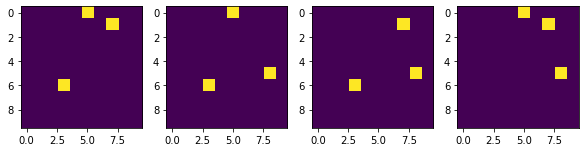

In [8]:
fig, ax = plt.subplots(1,len(agents),figsize=(10,10))
i= 0
for agent in agents:
    
    agent.get_other_agents(env)
    ax[i].imshow(agent.other_agent_positions)
    i +=1

In [9]:
episode = 0
minimal_size = 1000
batch_size = 32

In [10]:
return_list = []
for i in range(10):
    with tqdm(total=int(600), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            done = False
            episode += 1
            episode_return = 0
            env.reset()
            initiate_positions()
            while not done:
                deadagent = 0
                for agent in agents:
                    if agent.is_alive():
                        state = env.get_state(agent)
                        action = agent.take_action(state)
                        next_state, reward, done, _ = env.step(action,agent)
                        agent.buffer.add(state, action, reward, next_state, done)
                        if agent.buffer.size() > minimal_size:
                            b_s, b_a, b_r, b_ns, b_d = agent.buffer.sample(batch_size)
                            transition_dict = {
                                'states': b_s,
                                'actions': b_a,
                                'next_states': b_ns,
                                'rewards': b_r,
                                'dones': b_d
                            }
                            agent.update(transition_dict)
                        episode_return += reward
                    else:
                        deadagent += 1
                
                if deadagent == len(agents):
                    done = True

                pbar.set_postfix({
                'episode':
                '%d' % (num_episodes / 10 * i + i_episode + 1),
                'amount covered':
                '%.2f' % (env.amount_covered()),
                'return':
                '%.2f' % episode_return,
                'epsilon':
                '%.2f' % agents[0].epsilon,
                'agent 1 reward':
                '%.2f' % agents[0].reward,
                'agent 2 reward':
                '%.2f' % agents[1].reward,
                'agent 3 reward':
                '%.2f' % agents[2].reward,
                'agent 4 reward':
                '%.2f' % agents[3].reward,
            
                })
                pbar.update(1)
            return_list.append(episode_return)
            for agent in agents:            
                agent.update_epsilon(1/num_episodes)
                

                    

Iteration 9: 100%|██████████| 600/600 [00:12<00:00, 46.88it/s, episode=1000, amount covered=0.14, return=165.00, epsilon=0.00, agent 1 reward=50.75]


In [11]:
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0)) 
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

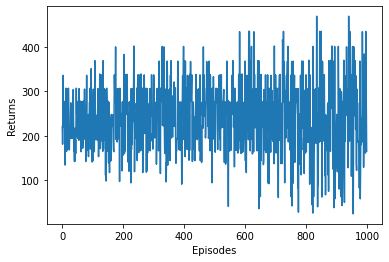

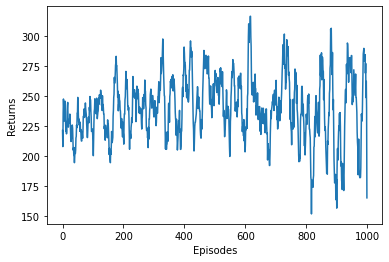

In [12]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.show()

mv_return = moving_average(return_list, 11)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.show()

In [13]:
env.amount_covered() * env.observation_space

14.000000000000002

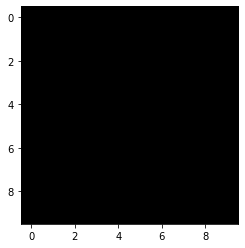

In [14]:
plt.imshow(env.reward_grid, cmap='gray')


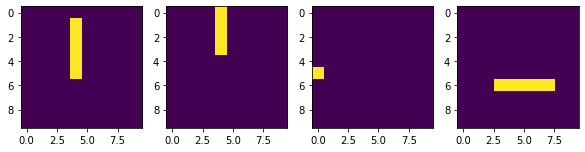

In [15]:
fig, ax = plt.subplots(1,4,figsize=(10,10))
i= 0
for agent in agents:
    
    agent.get_other_agents(env)
    ax[i].imshow(agent.coverage_grid)
    i +=1


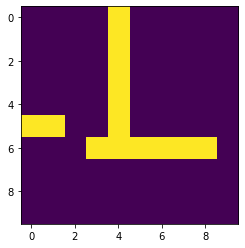

In [16]:
plt.imshow(env.coverage_grid, cmap='viridis', interpolation='nearest')